In [2]:
from schrodinger import Schrodinger2D, Rectangle
import numpy as np
import scipy.linalg as spl

def V(x, y):
    return x*x + y*y

problem = Schrodinger2D(V, Rectangle(-10, 10, -10, 10), gridSize=[30,30], maxBasisSize=14)
problem.eigenvalues(10)

[2.0000000005940253,
 3.999999994044647,
 3.999999994044653,
 5.999999987495555,
 6.0000005090240744,
 6.000000509024118,
 7.9999985284384225,
 7.999998528438496,
 8.000000502474956,
 8.000000502474995]

In [3]:
Bx, By = problem.Beta()
Lx, Ly = map(np.diag, problem.Lambda())
nx = Lx.shape[0]
ny = Ly.shape[0]
print(nx, ny)

420 420


In [4]:
Bx.shape

(900, 420)

In [5]:
A = np.hstack((Bx @ Lx, By @ Lx))
A = np.vstack((A, A))
R = np.block([[Bx, np.zeros(By.shape)], [np.zeros(Bx.shape), By]])

In [6]:
A.shape

(1800, 840)

In [7]:
U, s, Vh = spl.svd(R, full_matrices=False)
Es, vs = spl.eig(U.T @ A @ Vh.T @ np.diag(1/s))
len(Es)

840

In [8]:
sorted(np.real(Es[np.where(np.real(Es) > 0.5)]))[:20]

[1.9999999996458488,
 3.4582954661304144,
 3.4582954661304326,
 4.000000025353992,
 4.0000000253540575,
 4.885617619673953,
 4.88561763438316,
 5.9999736156629435,
 5.99997386806428,
 6.000000013494335,
 6.124518886532253,
 6.124519165248973,
 6.311819204946233,
 6.311819204946394,
 7.557133580465442,
 7.5571335804655355,
 7.737057719799939,
 7.73705790519544,
 7.999997777067869,
 7.9999977770679855]

In [9]:
by_residual = []
for E, c in zip(Es, (Vh.T @ vs).T):
    cx = c[:nx]
    cy = c[nx:]
    bcx = Bx @ cx
    bcy = By @ cy
    r1 = np.linalg.norm(Bx @ (Lx @ cx) + By @ (Ly @ cy) - E/2*(bcx + bcy))
    r2 = np.linalg.norm(bcx - bcy)
    by_residual.append((r1, r2, np.real(E)))

In [10]:
sr = sorted(by_residual)
r1, r2, e = zip(*sr)

plt.plot(e, r1, marker=".", ls='')
plt.plot(e, r2, marker=".", ls='')
plt.ylim(0, 1)

NameError: name 'plt' is not defined

In [ ]:
sorted(sr, key=lambda a:a[1])[:30]

In [11]:
import os

with open("nm_alternative_solve.tex", 'w') as f:
    step = 5
    for i in range(0, 15, step):
        r1s, r2s, es = zip(*list(filter(lambda a: a[1] < 1, sr))[i:i+step])

        print(r'\begin{tabular}{r|'+'r'*len(es)+'}', file=f)
        print('$E$', '&', ' & '.join(f"\\numprint{{{e:.6f}}}" for e in es),r'\\\hline', file=f)
        print('$r_1$', '&', ' & '.join(f"\\numprint{{{e:.0e}}}" for e in r1s).replace('e-0','e-'),r'\\', file=f)
        print('$r_2$', '&', ' & '.join(f"\\numprint{{{e:.0e}}}" for e in r2s).replace('e-0','e-'), file=f)
        print(r'\end{tabular}', file=f)
        print('', file=f)

/home/student/work/experiments/c4/nm_alternative_solve.tex


In [355]:
i = 675
E = Es[i]
r = (A - E * R) @ (Vh.T @ vs[:, i])
E, np.linalg.norm(r), np.max(np.abs(r))

((1.3734390985893864e-14+3.609780831172128e-15j),
 0.08285295736427621,
 0.007291906576238155)

In [252]:
np.argmin(Es)

675

In [138]:
import scipy.linalg as spl
import scipy.sparse.linalg as spsl


class Op(spsl.LinearOperator):
    def __init__(self, problem, dtype="float64"):
        self.Lx, self.Ly = problem.Lambda()
        n = self.Lx.shape[0] + self.Ly.shape[0]
        self.dtype = np.dtype(dtype)
        self.shape = (n, n)
        
        Bx, By = problem.Beta()
        self.Ry = spl.solve(Bx.T @ Bx, Bx.T @ By @ np.diag(self.Ly))
        self.Rx = spl.solve(By.T @ By, By.T @ Bx @ np.diag(self.Lx))
    
    def _matmat(self, c):
        nx = self.Lx.shape[0]
        cx = c[:nx, :]
        cy = c[nx:, :]
        return np.vstack((
            self.Lx[:, None] * cx + self.Ry @ cy,
            self.Rx @ cx + self.Ly[:, None] * cy,
        ))
    
    def _matvec(self, c):
        return self._matmat(c.reshape(c.shape[0], 1))


sorted(np.real(spsl.eigs(Op(problem), 10, return_eigenvectors=False, sigma=7)))

[6.000000013494332,
 6.00000010520505,
 6.000000105476046,
 6.311819204939557,
 6.311819204941632,
 7.737057719806785,
 7.737057905202785,
 7.9999977771164135,
 7.999997777116417,
 8.000000094756897]

In [ ]:
o.shape, nx, ny

In [107]:
o = Op(problem)
M = o.matmat(np.eye(o.shape[0]))

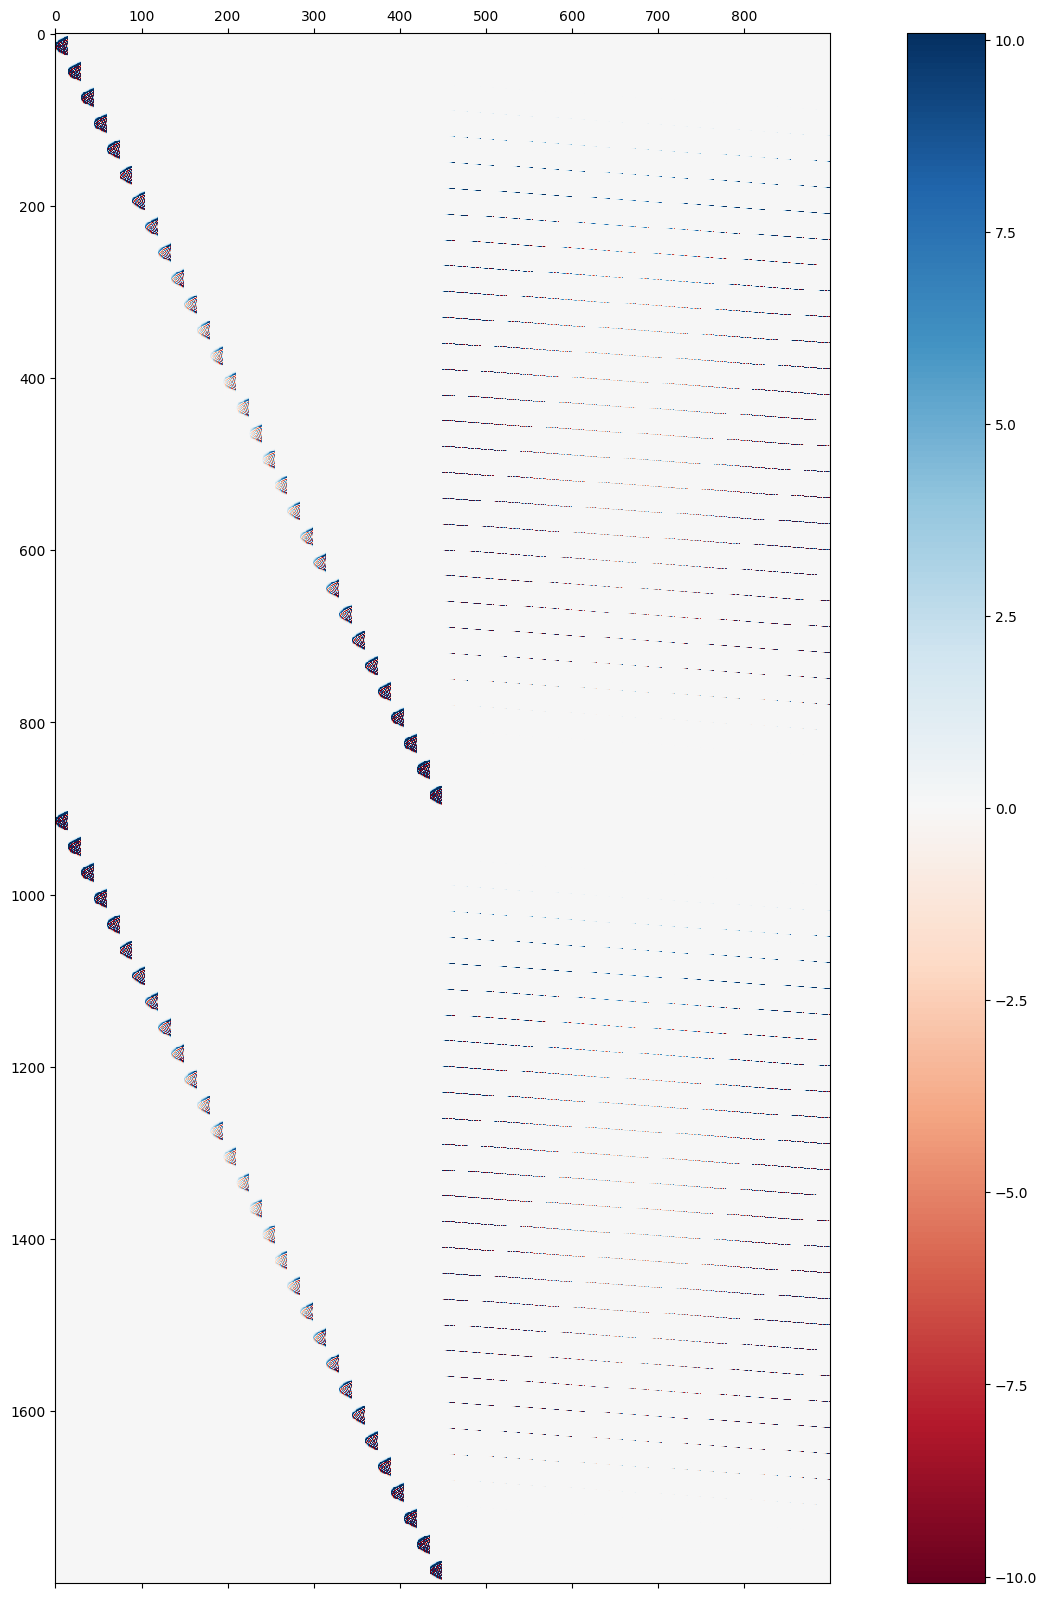

In [143]:
import matplotlib.pyplot as plt
import numpy as np

v = np.max(np.abs(r))

plt.matshow(A, cmap="RdBu", vmax=v, vmin=-v)
plt.colorbar()
plt.gcf().set_size_inches(20, 20)
plt.gcf().set_dpi(100)
plt.show()

In [43]:
f = plt.gcf()

<Figure size 432x288 with 0 Axes>

In [ ]:
f.set_size_inches